# pymc3 minimal example

In [1]:
import os
import numpy as np, pandas as pd
cwd = os.path.expanduser("/home/min/GIT/cnv-gene-mapping/data/deletion_simu_30_shape0.777_scale0.843")

## import X and y

In [3]:
X = pd.read_csv(f'{cwd}/block_51_53/deletion.genes.block30.for_simu.sample.combined.genes.block_51_53.gz', compression = "gzip", sep = "\t", header = None, dtype = float)
y = np.loadtxt(f'{cwd}/deletion.genes.block30.for_simu.sample.combined.y.gz', dtype = int)

In [4]:
pi_varbvs = 0.051366009925488
mu_varbvs = 0.783230896500752
si_varbvs = 0.816999481742865

## Spike and Slab model

In [5]:
import pymc3 as pm
import theano.tensor as tt

In [7]:
iteration = 10000
tune_prop = 0.25
seed = 1
n_chain = 6
n_core = 8
target_accept = 0.98

In [8]:
def get_model(y, X, pi0 = pi_varbvs, mu = mu_varbvs, sigma = si_varbvs, prevalence = 0.05, scale = True):
    case_prop = sum(y) / y.shape[0]
    invlogit = lambda x: 1/(1 + tt.exp(-x))
    upper = np.log(case_prop / (1-case_prop))
    lower = np.log(prevalence / (1-prevalence))
    model = pm.Model()
    with model:
        xi = pm.Bernoulli('xi', pi0, shape = X.shape[1]) # inclusion probability for each variable        
        if scale:
            # reparameterization to non-centered hierarchical model helps with sampling at hierarchical funnel
            # https://eigenfoo.xyz/bayesian-modelling-cookbook/
            # https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/
            # beta = pm.Normal('beta', mu = mu, sd = sigma, shape = X.shape[1]) # Prior for the non-zero coefficients
            beta_offset = pm.Normal('beta_offset', mu = 0, sd = 1, shape = X.shape[1]) # Prior for the non-zero coefficients
            alpha_offset = pm.distributions.continuous.Uniform("alpha_offset", lower = -1, upper = 1)
            beta = pm.Deterministic("beta", mu + beta_offset * sigma)
            alpha = pm.Deterministic("alpha", lower + (alpha_offset+1)/2*(upper - lower))
        else:
            beta = pm.Normal('beta', mu = mu, sd = sigma, shape = X.shape[1])
            alpha = pm.distributions.continuous.Uniform("alpha", lower = lower, upper = upper)
        p = pm.math.dot(X, xi * beta) # Deterministic function to map the stochastics to the output
        y_obs = pm.Bernoulli('y_obs', invlogit(p + alpha), observed = y)  # Data likelihood
    return model

In [9]:
model = get_model(y,X)

In [10]:
model

In [11]:
with model:
    trace1 = pm.sample(draws=iteration, random_seed = seed, cores = min(n_core, n_chain), progressbar = True, chains = n_chain, tune = int(tune_prop*iteration), nuts = {"target_accept": target_accept})

INFO: Multiprocess sampling (6 chains in 6 jobs)

INFO: CompoundStep

INFO: >BinaryGibbsMetropolis: [xi]

INFO: >NUTS: [alpha_offset, beta_offset]

Sampling 6 chains, 0 divergences: 100%|##########| 75000/75000 [36:27<00:00, 34.29draws/s]


In [12]:
pm.summary(trace1).round(4)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
xi[0],1.000,0.000,1.000,1.000,0.000,0.000,60000.0,60000.0,60000.0,60000.0,NaN
xi[1],0.015,0.123,0.000,0.000,0.001,0.000,43090.0,43090.0,43090.0,43090.0,1.0
xi[2],0.032,0.176,0.000,0.000,0.001,0.001,42036.0,42036.0,42036.0,42036.0,1.0
beta_offset[0],1.131,0.391,0.396,1.858,0.002,0.001,42810.0,37975.0,43438.0,33265.0,1.0
beta_offset[1],-0.006,1.004,-1.943,1.819,0.005,0.005,45691.0,24893.0,45714.0,38542.0,1.0
beta_offset[2],-0.010,1.000,-1.903,1.855,0.005,0.004,45171.0,25065.0,45213.0,36553.0,1.0
alpha_offset,0.992,0.006,0.982,1.000,0.000,0.000,41540.0,41330.0,26786.0,16696.0,1.0
beta[0],1.707,0.319,1.107,2.301,0.002,0.001,42810.0,40368.0,43438.0,33265.0,1.0
beta[1],0.778,0.821,-0.804,2.269,0.004,0.003,45691.0,34427.0,45714.0,38542.0,1.0
beta[2],0.775,0.817,-0.772,2.298,0.004,0.003,45171.0,34812.0,45213.0,36553.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7981d79e50>,
      dtype=object)

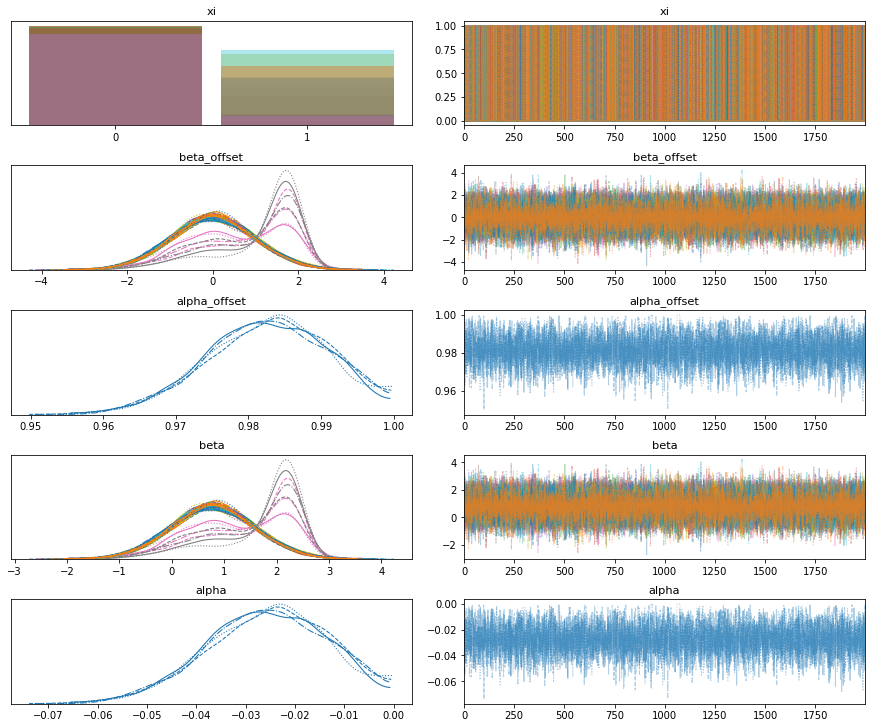

In [11]:
pm.traceplot(trace1)

In [11]:
pd.DataFrame({'inclusion_probability': np.apply_along_axis(np.mean, 0, trace1['xi']),
                        'beta': np.apply_along_axis(np.mean, 0, np.multiply(trace1["beta"], trace1["xi"])),
                        'beta_given_inclusion': np.apply_along_axis(np.sum, 0, trace1['xi'] * trace1['beta']) / np.apply_along_axis(np.sum, 0, trace1['xi'])
                        })

,inclusion_probability,beta,beta_given_inclusion
0,0.1125,0.092210,0.819645
1,0.1192,0.097817,0.820611
2,0.1065,0.089244,0.837971
3,0.0761,0.050698,0.666200
4,0.0868,0.059761,0.688490
5,0.0588,0.031612,0.537617
6,0.6006,1.222470,2.035415
7,0.4684,0.935142,1.996461
8,0.0289,0.009623,0.332984
9,0.0246,0.006925,0.281514


In [19]:
pd.DataFrame({'inclusion_probability': np.apply_along_axis(np.mean, 0, trace1['xi']),
                        'beta': np.apply_along_axis(np.mean, 0, np.multiply(trace1["beta"], trace1["xi"])),
                        'beta_given_inclusion': np.apply_along_axis(np.sum, 0, trace1['xi'] * trace1['beta']) / np.apply_along_axis(np.sum, 0, trace1['xi'])
                        })

,inclusion_probability,beta,beta_given_inclusion
0,0.1185,0.095629,0.806999
1,0.1250,0.102045,0.816362
2,0.1225,0.101824,0.831219
3,0.0690,0.045162,0.654525
4,0.0780,0.054559,0.699479
5,0.0535,0.028675,0.535987
6,0.4555,0.920394,2.020624
7,0.5955,1.238234,2.079319
8,0.0325,0.010554,0.324732
9,0.0205,0.008191,0.399540
